# Performing combined approximation, continuity and energy objective optimization experiments

In this Jupyter notebook we perform tests for our paper.

Version 0.1  
Date: 2025-04-10  
Current version: hannes.waclawek@fh-salzburg.ac.at  

In [1]:
import copy

# Imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
import multiprocessing as mp
from itertools import repeat

from tfspline import model, parallel, plot, sampledata

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from pickleshare import PickleShareDB
db = PickleShareDB('./picklesharedb')

%load_ext autoreload
%autoreload 2

2025-04-11 09:00:10.001970: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-11 09:00:10.005404: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-11 09:00:10.048040: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-11 09:00:10.744594: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Energy minimization

In order to reduce the forces applied to a cam-follower system, we want to optimize the cam's acceleration curve.
To do so, we can quantify total curvature as

\begin{align*}
    \int_I f''(x)^2 \; \mathrm{d}x
\end{align*}

for a cam profile $f$ over the interval $I$.
Considering our individual polynomial segments $p_i$, we receive

\begin{align*}
    \int_I f''(x)^2 \; \mathrm{d}x
      &= \sum_{i=1}^m \int_{I_i} p''_i(x)^2 \; \mathrm{d}x
\end{align*}

with
\begin{align*}
    & \int_{I_i} p''_i(x)^2 \; \mathrm{d}x \\
    &= \int_{I_i} \left( \sum_{j=2}^d \alpha_{i,j} \cdot j (j-1) x^{j-2} \right)^2  \; \mathrm{d}x \\
    %&= \int_{I_i} \left( \sum_{j=2}^d \alpha_{i,j} \cdot j (j-1) x^{j-2} \right) \cdot \\
    %&  \quad \left( \sum_{k=2}^d \alpha_{i,k} \cdot k (k-1) x^{k-2} \right) \; \mathrm{d}x \\
    &= \sum_{j=2}^d \sum_{k=2}^d \alpha_{i,j} \alpha_{i,k} j k (j-1) (k-1) \cdot
        \int_{I_i} x^{j+k-4} \; \mathrm{d}x \\
    &= \sum_{j=2}^d \sum_{k=2}^d \frac{\alpha_{i,j} \alpha_{i,k} j k (j-1) (k-1)}{j+k-3}
        \cdot \left. x^{j+k-3} \right|_{\xi_{i-1}}^{\xi_i}
\end{align*}

representing total acceleration for each individual polynomial segment.
Plugging in the boundary points for the definite integral and generalizing 
to the overall spline with $m$ segments we can then formulate total curvature loss as 

\begin{align*}
    \ell_\text{E} = \sum_{i=1}^m \sum_{j=2}^d \sum_{k=2}^d \alpha_{i,j} \alpha_{i,k} \frac{j k (j-1) (k-1)}{j+k-3}
        \cdot \left(\xi_i^{j+k-3}-\xi_{i-1}^{j+k-3}\right). \\
\end{align*}

# 3-objective optimization

Previously, we optimized for continuity error $\ell_{\text{CK}}$ and approximation error $\ell_2$ utilizing the loss function

\begin{align}
    \ell = \alpha \ell_{\text{CK}} + (1-\alpha) \ell_2,
\end{align}

with $0 \le \alpha \le 1$. 

We now have three objectives, $\ell_2, \ell_{\text{CK}}, \ell_{\text{E}}$,
and still want to weight them in a way that the sum of the weights equals $1$.  
Therefore, we introduce two independent parameters \( \alpha \) and \( \beta \),
and define the weighted sum as:  

\begin{align}
    \ell = \alpha \ell_{\text{CK}} + \beta \ell_2 + (1-\alpha-\beta) \ell_{\text{E}},
\end{align}

where $\alpha, \beta \geq 0$ and $\alpha + \beta \leq 1$.  
   
- $\alpha$ controls the emphasis on $\ell_{\text{CK}}$  
- $\beta$ controls the emphasis on $\ell_2$  
- The remaining weight $(1 - \alpha - \beta)$ is assigned to $\ell_{\text{E}}$ 
- If $\alpha + \beta = 1$, then $\ell_{\text{E}}$  has no weight  
- If $\alpha + \beta = 0$, then only $\ell_{\text{E}}$ is considered  

# What we know from previous findings

## General

Continuity optimization works and results converge.

## Alpha

We increase alpha with rising variance as more emphasis on continuity optimization is required:
- Simple rise: 0.1
- Sine: 0.1
- Sine with varying frequency: 0.6
- Noisy Sine with varying frequency: 0.999

## Learning rate and number of epochs  
 
Contrary to the single approximation target we see that a lower learning rate of 0.1 is beneficial.
Also contrary to the single approximation target, the combined C^k and approximation goal now leads to a non-convex loss landscape
and we see spikes in the loss curve at some epoch ranges. This is expected, if optimization leaves a local optima towards a lower optimum.
Early stopping and reverting to the best loss / coefficients of the training cycle can prevent ending up with an unsatisfiable local optimum result.

**A learning rate of 0.1 seems to be a reasonable choice for all bases.**
**2000 epochs seem to be sufficient. With early stopping we can have less.**
  
## Number of polynomials
  
Raising the number of polynomials, as expected, reduces remaining losses and, for Chebyshev basis, shows less spikes in remaining losses.
If we increase the number of segments, the variance in the individual segments input data is effectively decreased.  
A learning rate of 0.1 still is good for more polynomials. 

## Optimizers  
  
Chebyshev basis is clearly outperforming Power Basis in regard to all observed optimizers and input point sets.
**None of the optimizers manage to surpass the l2 optimum with Power basis in the given 5000 epochs for the lowest variance input data (name in this notebook: Simple rise curve).**
**There are, however, several optimizers that achieve this with Chebyshev basis.**
The more variance is in the input data, the higher is the loss for the l2 baseline with CK loss.
The more variance is in the input data, the more optimizers (also with Power basis) manage to surpass this l2 baseline.
The following optimizer candidates surpass the l2 baseline with all observed input data:
1. adam, amsgrad
2. adamax
3. adagrad, ftrl
4. nadam

Considering all observed input data, Adam AMSGrad is the best candidate.
With least squares fit initialization of polynomial coefficients, Power basis gets competitive again.
However, Chebyshev basis with AMSGrad still shows the best convergence behaviour also in that scenario.

## AMSGrad optimizer parameters

Default parameters perform best for Power and Chebyshev basis.

## $C^k$ loss regularization

Results with $C^k$ loss regularization outperform results without $C^k$ loss regularization for all candidate optimizers.
The more variance is in the input data, the closer is the gap. 


## Data

We seek data were optimizing for $\ell_{\text{CK}}$ and $\ell_{\text{E}}$ is not sufficient to produce a "smooth" result.
We want to base our argument on one of two cases:
 - Trajectories that contain measuring errors (i.e. noise)
 - Trajectories that are not $C^k$ continuous and therefore an approximation thereof is prone to oscillating behaviour

In both cases we expect unwanted oscillation in the result that can be smoothened out via $\ell_{\text{E}}$.

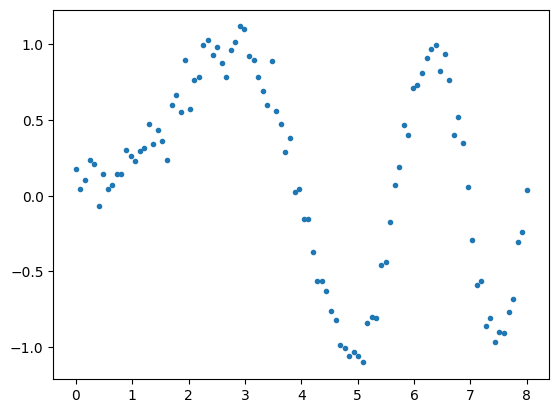

In [2]:
xs2 = np.linspace(0, 1, 100)
ysinvar = np.sin(xs2**2 * 4 * np.pi)
xs2 = sampledata.rescale_input_data(xs2, 8)

# Explicit seed to have reproducible testsets
np.random.seed(0)
ys2gauss_scale = 0.1
ys2 = ysinvar + np.random.normal(scale=ys2gauss_scale, size=len(ysinvar))

plt.plot(xs2, ys2, '.')

## Determine pareto optimal solutions

For a fixed $\alpha \in [0.8, 0.85, 0.9, 0.95, 1]$, we determine $\ell_E$ and $\ell_2$ for $\beta \in [\frac{1-\alpha}{16}, \frac{1-\alpha}{8}, \frac{1-\alpha}{4}, \frac{1-\alpha}{2}, \frac{1-\alpha}{1}]$ .  
We use $C^2$-continuity to have more free parameters.

In [3]:
ck = 2
polynum=16
degree = 7
initialization = 'zero'
learning_rate = 0.1
ck_regularization=False
cyclic=True
early_stopping = True
patience=100
opt = 'AMSGRAD'
basis = 'power'
epochs = 1000
mode = 'energy_pareto'

In [9]:
kwargs = {'data_x': xs2, 'data_y': ys2, 'polynum': polynum, 'ck': ck, 'degree': degree, 'optimizer': opt, 
          'n_epochs': epochs, 'basis': basis, 'learning_rate': learning_rate, 'ck_regularization': ck_regularization, 
          'mode': mode, 'early_stopping': early_stopping, 'patience': patience, 'initialization': initialization, 'seed': 0}

In [5]:
alphas = [0.8, 0.85, 0.9, 0.95]
denominators = [16, 8, 4, 2, 1]

alpha_beta_pairs = []

for alpha in alphas:
    for d in denominators:
        beta = (1 - alpha) / d
        alpha_beta_pairs.append([alpha, beta])

params = np.array(alpha_beta_pairs)

print(params)

[[0.8      0.0125  ]
 [0.8      0.025   ]
 [0.8      0.05    ]
 [0.8      0.1     ]
 [0.8      0.2     ]
 [0.85     0.009375]
 [0.85     0.01875 ]
 [0.85     0.0375  ]
 [0.85     0.075   ]
 [0.85     0.15    ]
 [0.9      0.00625 ]
 [0.9      0.0125  ]
 [0.9      0.025   ]
 [0.9      0.05    ]
 [0.9      0.1     ]
 [0.95     0.003125]
 [0.95     0.00625 ]
 [0.95     0.0125  ]
 [0.95     0.025   ]
 [0.95     0.05    ]]


In [8]:
result = parallel.job(params[0], kwargs)

.#

In [25]:
pool = mp.Pool(mp.cpu_count())
results = pool.starmap(parallel.job, zip(params, repeat(kwargs)))

............#.#.Early stop: Achieved best result after 519 epochs. Exiting.
#.Early stop: Achieved best result after 614 epochs. Exiting.
Early stop: Achieved best result after 615 epochs. Exiting.
#.#.Early stop: Achieved best result after 799 epochs. Exiting.
#.Early stop: Achieved best result after 825 epochs. Exiting.
#.Early stop: Achieved best result after 875 epochs. Exiting.
#.Early stop: Achieved best result after 897 epochs. Exiting.
#####Early stop: Achieved best result after 646 epochs. Exiting.
#######

In [ ]:
#db["energy_pareto_results"] = results

In [15]:
results = db["energy_pareto_results"]

continuous_results = []

for r in results:
    params = r[0]
    pp = model.get_spline_from_coeffs(r[-1], xs2, ys2, basis=basis, ck=ck)
    pp._establish_continuity()
    loss = pp.get_total_loss()
    continuous_results.append([copy.deepcopy(params), loss[0], loss[1], loss[2], loss[-1], copy.deepcopy(pp.coeffs)])

db["energy_pareto_results_continuous"] = continuous_results

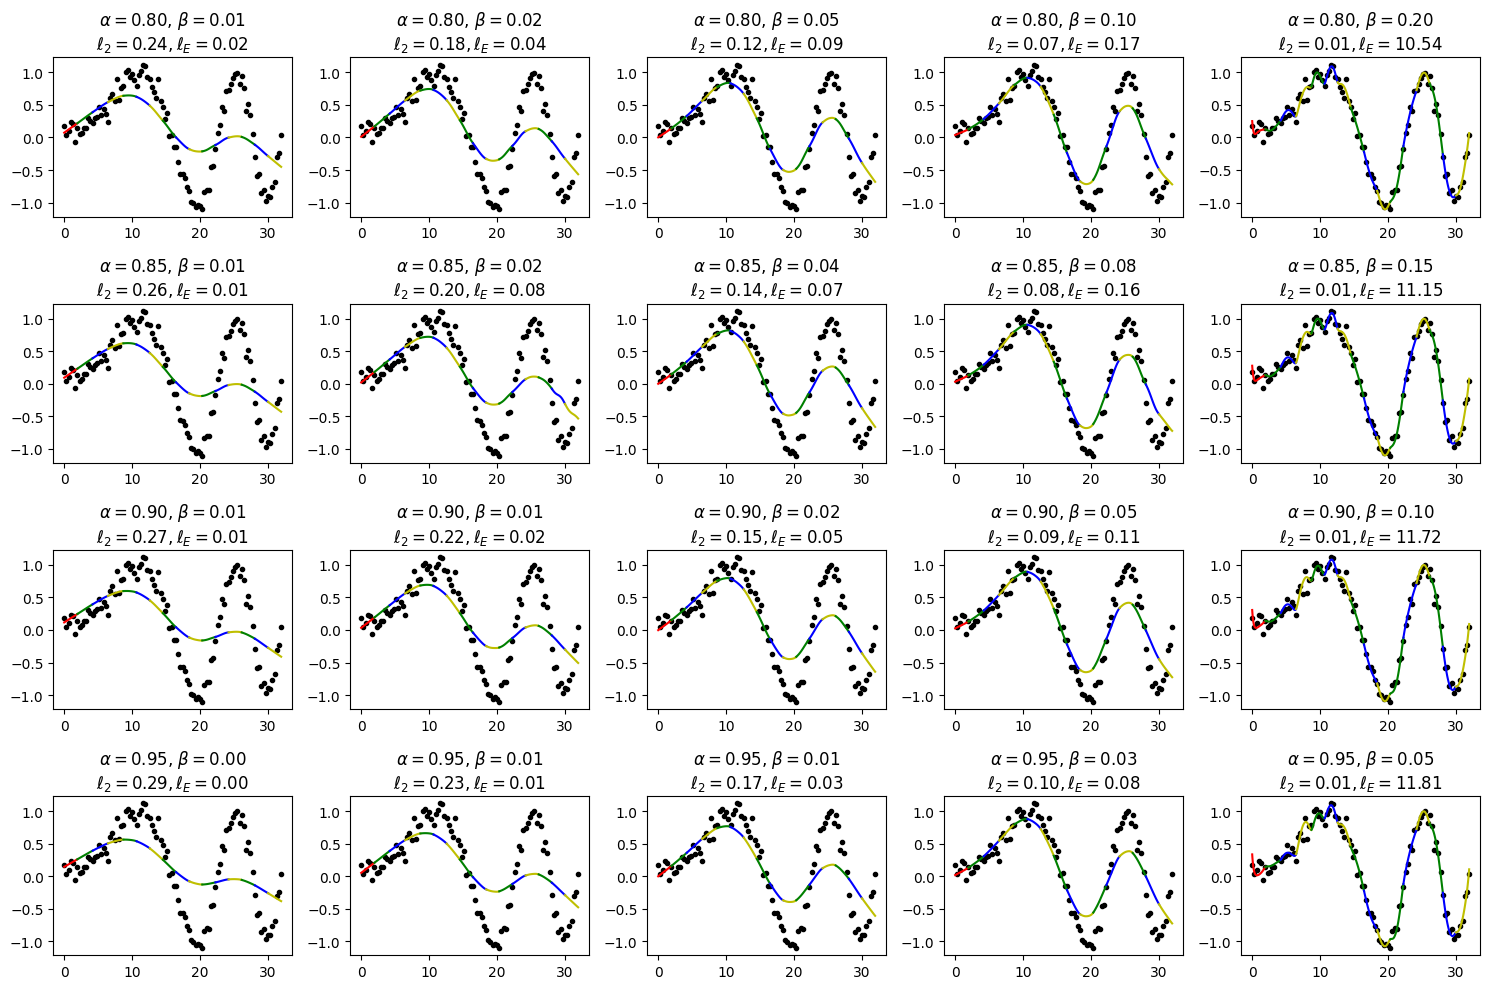

In [42]:
continuous_results = db["energy_pareto_results_continuous"]

rows = len(alphas)
cols = len(denominators)

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
k = 0

for i in range(rows):
    for j in range(cols):
        ax = axes[i, j]  
        plot.plot_spline(model.get_spline_from_coeffs(continuous_results[k][-1], xs2, ys2, basis=basis, ck=ck), ax=ax) 
        ax.set_title(r'$\alpha = $' f"{continuous_results[k][0]['param_value'][0]:.2f}" r', $\beta = $' f"{continuous_results[k][0]['param_value'][1]:.2f}\n" r'$\ell_2 = $' f"{continuous_results[k][2]:.2f}" r'$, \ell_E = $' f"{continuous_results[k][4]:.2f}")
        k += 1

plt.tight_layout()

In [33]:
colors = list(mcolors.TABLEAU_COLORS.keys())
color_map = plt.get_cmap('gist_rainbow')
mycolor = lambda i: color_map(1.*i/len(alphas))

Text(0, 0.5, '$\\ell_E$')

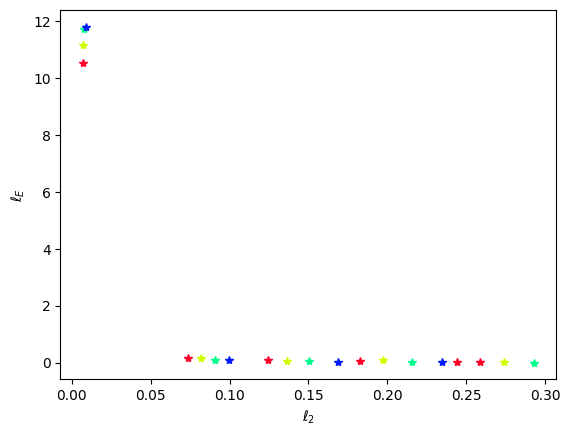

In [ ]:
continuous_results = db["energy_pareto_results_continuous"]

fig, ax = plt.subplots()
k = 0
d = len(denominators)

for i, r in enumerate(continuous_results):
    ax.plot(r[2], r[4], '*', color=mycolor(k)) 
    if i % d == 0 and i != 0:
        k+=1

ax.set_xlabel(r'$\ell_2$')
ax.set_ylabel(r'$\ell_E$')

### Improve parameter range and add periodicity

In [8]:
#alphas = [0.8, 0.85, 0.9, 0.95] --> too less spread
#denominators = [16, 8, 4, 2, 1] --> no difference for values 2, 4, …

alphas = [0.1, 0.5, 0.75, 0.99]
betafactors = [1, 0.75, 0.5, 0.25, 0.01]

# weight for l_CK = alpha, l_2 = (1-alpha)*betafactor, l_E = (1-alpha)*(1-betafactor)
# ==> betafactor = 0 means l_2 has zero weight ==> nonsense
# ==> betafactor = 1 means l_E has zero weight ==> baseline (non-energy optimized)

alpha_beta_pairs = []

for alpha in alphas:
    for betafactor in betafactors:
        beta = (1 - alpha) * betafactor
        alpha_beta_pairs.append([alpha, beta])

params = np.array(alpha_beta_pairs)

print(params)

[[1.000e-01 9.000e-01]
 [1.000e-01 6.750e-01]
 [1.000e-01 4.500e-01]
 [1.000e-01 2.250e-01]
 [1.000e-01 9.000e-03]
 [5.000e-01 5.000e-01]
 [5.000e-01 3.750e-01]
 [5.000e-01 2.500e-01]
 [5.000e-01 1.250e-01]
 [5.000e-01 5.000e-03]
 [7.500e-01 2.500e-01]
 [7.500e-01 1.875e-01]
 [7.500e-01 1.250e-01]
 [7.500e-01 6.250e-02]
 [7.500e-01 2.500e-03]
 [9.900e-01 1.000e-02]
 [9.900e-01 7.500e-03]
 [9.900e-01 5.000e-03]
 [9.900e-01 2.500e-03]
 [9.900e-01 1.000e-04]]


In [42]:
kwargs = {'data_x': xs2, 'data_y': ys2, 'polynum': polynum, 'ck': ck, 'degree': degree, 'optimizer': opt, 
          'n_epochs': epochs, 'basis': basis, 'learning_rate': learning_rate, 'ck_regularization': ck_regularization, 
          'mode': mode, 'early_stopping': early_stopping, 'patience': patience, 'initialization': initialization, 'seed': 0, 'periodic': True}

In [43]:
pool = mp.Pool(mp.cpu_count())
results = pool.starmap(parallel.job, zip(params, repeat(kwargs)))

db["energy_pareto_results_2_periodic"] = results

............Early stop: Achieved best result after 101 epochs. Exiting.
#.Early stop: Achieved best result after 113 epochs. Exiting.
#.Early stop: Achieved best result after 117 epochs. Exiting.
#.Early stop: Achieved best result after 281 epochs. Exiting.
#.#.#.#.Early stop: Achieved best result after 476 epochs. Exiting.
#.Early stop: Achieved best result after 581 epochs. Exiting.
#Early stop: Achieved best result after 622 epochs. Exiting.
#Early stop: Achieved best result after 517 epochs. Exiting.
##Early stop: Achieved best result after 309 epochs. Exiting.
#Early stop: Achieved best result after 759 epochs. Exiting.
####Early stop: Achieved best result after 667 epochs. Exiting.
###

In [44]:
results = db["energy_pareto_results_2_periodic"]

continuous_results = []

for r in results:
    params = r[0]
    pp = model.get_spline_from_coeffs(r[-1], xs2, ys2, basis=basis, ck=ck)
    pp.cyclic = True
    pp.periodic = True
    pp._establish_continuity()
    loss = pp.get_total_loss()
    continuous_results.append([copy.deepcopy(params), loss[0], loss[1], loss[2], loss[-1], copy.deepcopy(pp.coeffs)])

db["energy_pareto_results_continuous_2_periodic"] = continuous_results

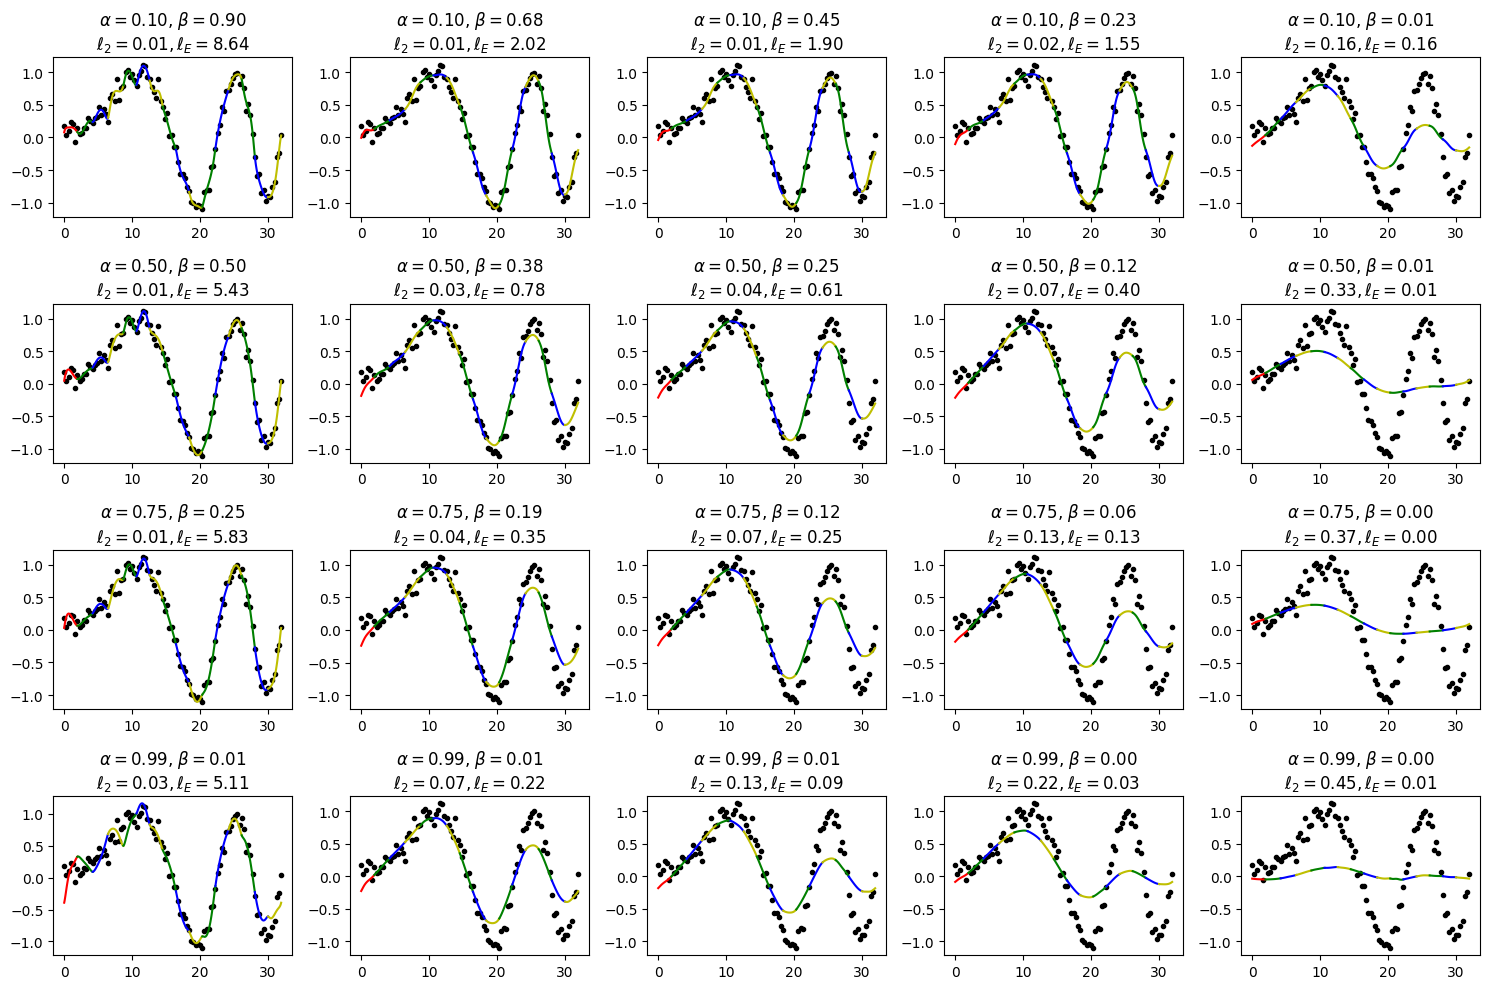

In [45]:
continuous_results = db["energy_pareto_results_continuous_2_periodic"]

rows = len(alphas)
cols = len(betafactors)

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
k = 0

for i in range(rows):
    for j in range(cols):
        ax = axes[i, j]  
        plot.plot_spline(model.get_spline_from_coeffs(continuous_results[k][-1], xs2, ys2, basis=basis, ck=ck), ax=ax) 
        ax.set_title(r'$\alpha = $' f"{continuous_results[k][0]['param_value'][0]:.2f}" r', $\beta = $' f"{continuous_results[k][0]['param_value'][1]:.2f}\n" r'$\ell_2 = $' f"{continuous_results[k][2]:.2f}" r'$, \ell_E = $' f"{continuous_results[k][4]:.2f}")
        k += 1

plt.tight_layout()

2025-04-11 09:00:17.827620: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


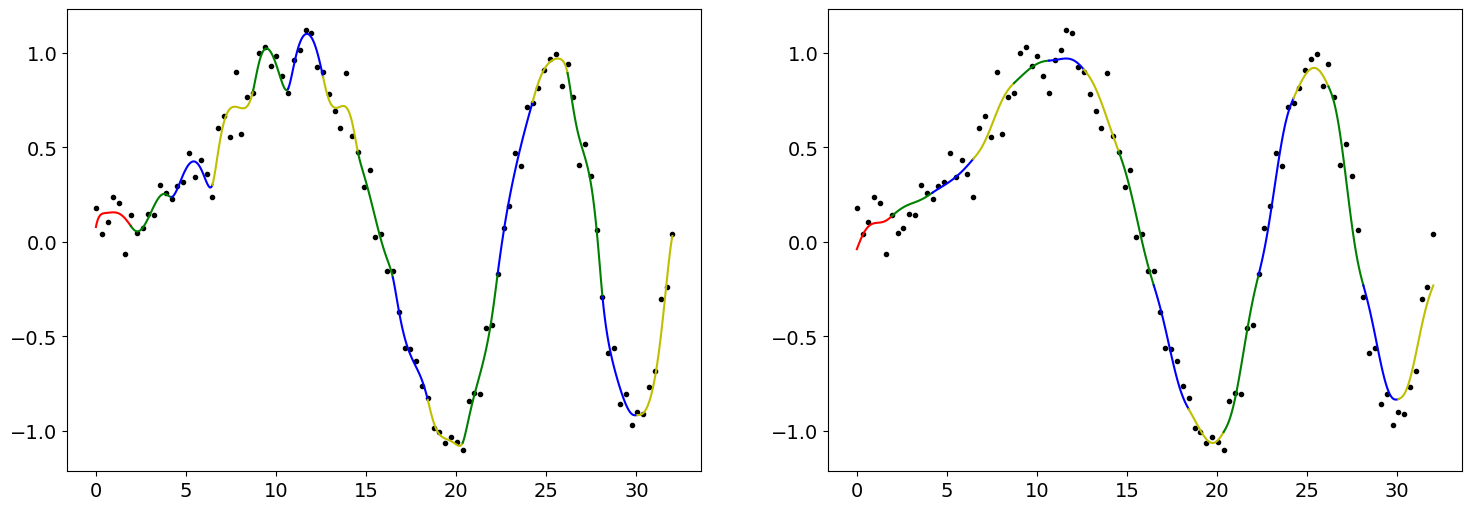

In [4]:
continuous_results = db["energy_pareto_results_continuous_2_periodic"]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(18)
fig.set_figheight(6)
ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)

pp1 = 0
pp2 = 2

plot.plot_spline(model.get_spline_from_coeffs(continuous_results[pp1][-1], xs2, ys2, basis=basis, ck=ck), ax=ax1) 
#ax1.set_title(r'$\alpha = $' f"{continuous_results[pp1][0]['param_value'][0]:.2f}" r', $\beta = $' f"{continuous_results[pp1][0]['param_value'][1]:.2f}\n" r'$\ell_2 = $' f"{continuous_results[pp1][2]:.2f}" r'$, \ell_E = $' f"{continuous_results[pp1][4]:.2f}")
plot.plot_spline(model.get_spline_from_coeffs(continuous_results[pp2][-1], xs2, ys2, basis=basis, ck=ck), ax=ax2) 
#ax2.set_title(r'$\alpha = $' f"{continuous_results[pp2][0]['param_value'][0]:.2f}" r', $\beta = $' f"{continuous_results[pp2][0]['param_value'][1]:.2f}\n" r'$\ell_2 = $' f"{continuous_results[pp2][2]:.2f}" r'$, \ell_E = $' f"{continuous_results[pp2][4]:.2f}")


#plt.tight_layout()

In [58]:
fig.savefig("curves.pdf", bbox_inches='tight')

In [21]:
def is_point_pareto_optimal(point, points):
    """A point is pareto optimal, if there is no other point that is better
    (i.e. lower coordinate) in _both_ dimensions"""
    for other in points:
        if other[0] < point[0] and other[1] < point[1]:
                return False
    return True

def results_to_points(results):
    ret = []
    for r in results:
        ret.append((r[2], r[4]))
    return ret

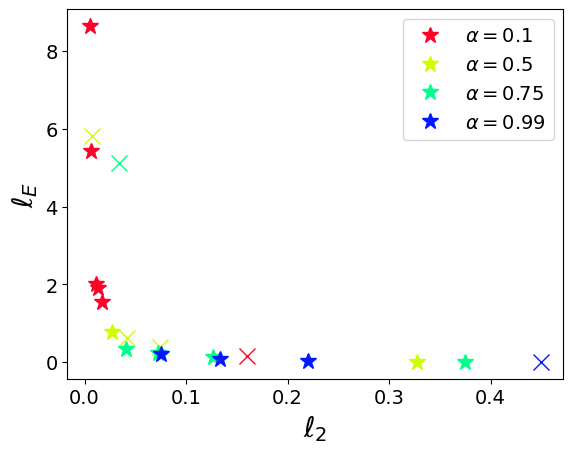

In [28]:
continuous_results = db["energy_pareto_results_continuous_2_periodic"]
points = results_to_points(continuous_results)

colors = list(mcolors.TABLEAU_COLORS.keys())
color_map = plt.get_cmap('gist_rainbow')
mycolor = lambda i: color_map(1.*i/len(alphas))

fig, ax = plt.subplots()
k = 0
d = len(betafactors)

l=r'$\alpha = $' f'{alphas[k]}'

for i, p in enumerate(points):
    marker = '*' if is_point_pareto_optimal(p, points) else 'x'
    ax.plot(p[0], p[1], marker, color=mycolor(k), label=l, markersize=12) 
    l=None
    if i % d == 0 and i != 0:
        k+=1
        l=r'$\alpha = $' f'{alphas[k]}'

ax.set_xlabel(r'$\ell_2$', fontsize=20)
ax.set_ylabel(r'$\ell_E$', fontsize=20)
ax.tick_params(labelsize=14)
ax.legend(loc='best', fontsize=14)

In [29]:
fig.savefig("alpha_beta_sweep.pdf", bbox_inches='tight')